## Core Libraries and Configurations

In [16]:
# Core libraries
import pandas as pd
import polars as pl
from datetime import datetime
import numpy as np

# Internal data access
from op_analytics.coreutils.duckdb_inmem.client import init_client, register_parquet_relation
# from op_analytics.coreutils.clickhouse.oplabs import run_query_oplabs

# configurations
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import config
from helper import fetch_eip1559_params, plot_base_fee_and_fullness
from core_eip1559 import compute_next_base_fee, validate_next_base_fee, add_fullness_metrics, compute_base_fee_elasticity

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-whitegrid")  # clean background
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "sans-serif",
    "font.sans-serif": ["Inter", "DejaVu Sans"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# config
CHAIN = config.CHAIN
BLOCK_DATE = config.BLOCK_DATE

## Pull Data 
EIP-1559 parameters, blocks


In [3]:
# pull the eip1559 params on BLOCK_DATE
eip1559_params_output = fetch_eip1559_params(CHAIN, BLOCK_DATE)
eip1559_params_output

2025-11-25 13:51:14 [debug    ] connecting to OPLABS Clickhouse client... filename=client.py lineno=56 process=48649
2025-11-25 13:51:14 [info     ] loaded vault from .env file    filename=vault.py lineno=32 process=48649
2025-11-25 13:51:14 [debug    ] loaded vault: 28 items         filename=vault.py lineno=79 process=48649
2025-11-25 13:51:16 [debug    ] initialized OPLABS Clickhouse client. filename=client.py lineno=61 process=48649
✅ Fetched EIP-1559 params for base (2025-08-16)


eip1559_elasticity,eip1559_denominator,gas_limit,latest_block_number,latest_block_timestamp,basefee_scalar,operator_fee_constant,operator_fee_scalar
u64,u64,u64,u64,u32,u64,u64,u64
3,50,150000000,23151069,1755316751,2269,0,0


In [4]:
# get the blocks data
parquet_paths = [
    f"gs://oplabs-tools-data-sink/ingestion/blocks_v1/chain={CHAIN}/dt={BLOCK_DATE}/*.parquet"
]

# Load into DuckDB
ctx = init_client()
block_view = register_parquet_relation("block_view", parquet_paths)

2025-11-25 13:51:16 [info     ] initialized duckdb at /var/folders/80/jqw6kmgj7j34j0x4mcs6hcl00000gn/T/wamaf845/op-analytics.duck.db filename=client.py lineno=118 process=48649
2025-11-25 13:51:16 [info     ] create duckddb gcs secret      filename=client.py lineno=66 process=48649
2025-11-25 13:51:27 [info     ] registered view: 'block_view' using 1 parquet paths filename=client.py lineno=319 process=48649


In [6]:
# Get samples 
df_sample = ctx.client.sql(f"SELECT * FROM {block_view} ORDER BY number LIMIT 10000").pl()

# convert unix timestamp to datetime

df_sample = df_sample.with_columns(
    pl.col("timestamp").map_elements(lambda x: datetime.fromtimestamp(x)).alias("datetime")
)
print(df_sample.head())

df_sample.schema

shape: (5, 25)
┌─────────┬──────────┬────────────┬──────────┬───┬──────────────┬───────┬────────────┬─────────────┐
│ network ┆ chain_id ┆ timestamp  ┆ number   ┆ … ┆ transaction_ ┆ chain ┆ dt         ┆ datetime    │
│ ---     ┆ ---      ┆ ---        ┆ ---      ┆   ┆ count        ┆ ---   ┆ ---        ┆ ---         │
│ str     ┆ i32      ┆ u32        ┆ i64      ┆   ┆ ---          ┆ str   ┆ date       ┆ datetime[μs │
│         ┆          ┆            ┆          ┆   ┆ i64          ┆       ┆            ┆ ]           │
╞═════════╪══════════╪════════════╪══════════╪═══╪══════════════╪═══════╪════════════╪═════════════╡
│ mainnet ┆ 8453     ┆ 1755302401 ┆ 34256527 ┆ … ┆ 224          ┆ base  ┆ 2025-08-16 ┆ 2025-08-16  │
│         ┆          ┆            ┆          ┆   ┆              ┆       ┆            ┆ 08:00:01    │
│ mainnet ┆ 8453     ┆ 1755302403 ┆ 34256528 ┆ … ┆ 266          ┆ base  ┆ 2025-08-16 ┆ 2025-08-16  │
│         ┆          ┆            ┆          ┆   ┆              ┆       ┆   

/var/folders/80/jqw6kmgj7j34j0x4mcs6hcl00000gn/T/ipykernel_48649/3729048975.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_sample = df_sample.with_columns(


Schema([('network', String),
        ('chain_id', Int32),
        ('timestamp', UInt32),
        ('number', Int64),
        ('hash', String),
        ('parent_hash', String),
        ('nonce', String),
        ('sha3_uncles', String),
        ('logs_bloom', String),
        ('transactions_root', String),
        ('state_root', String),
        ('receipts_root', String),
        ('withdrawals_root', String),
        ('miner', String),
        ('difficulty', Float64),
        ('total_difficulty', Float64),
        ('size', Int64),
        ('base_fee_per_gas', Int64),
        ('gas_used', Int64),
        ('gas_limit', Int64),
        ('extra_data', String),
        ('transaction_count', Int64),
        ('chain', String),
        ('dt', Date),
        ('datetime', Datetime(time_unit='us', time_zone=None))])

## Run Base Fee Simulation EIP-1559

In [7]:
# simulate the next base fee
df_simulate = compute_next_base_fee(
    df_sample,
    eip1559_elasticity=eip1559_params_output["eip1559_elasticity"],
    eip1559_denominator=eip1559_params_output["eip1559_denominator"],
)

# compare the predicted next base fee with the actual next base fee
df_output, summary = validate_next_base_fee(df_simulate)
summary

{'rows_compared': 9999, 'mismatches': 0}

In [8]:
# inspect predicted vs actual next base fee
df_output["diff"].value_counts().sort(by="diff")

diff,count
i64,u32
null,1
0,3933
1,6066


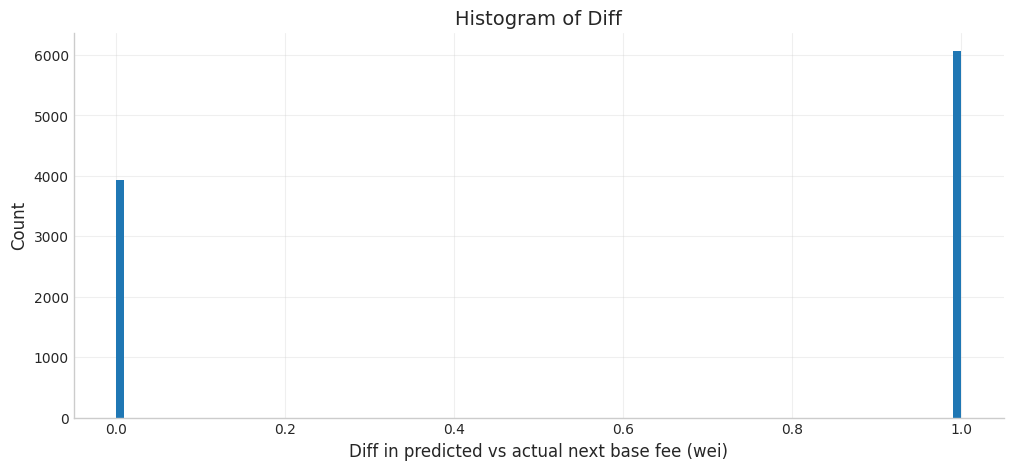

In [9]:
# plot the histogram of diff
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df_output["diff"], bins=100)
ax.set_title("Histogram of Diff")
ax.set_xlabel("Diff in predicted vs actual next base fee (wei)")
ax.set_ylabel("Count")
plt.show()

In [10]:
# find out where diff is the max
row_max_diff = df_output.filter(pl.col("diff") == df_output["diff"].max())
row_max_diff

network,chain_id,timestamp,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,withdrawals_root,miner,difficulty,total_difficulty,size,base_fee_per_gas,gas_used,gas_limit,extra_data,transaction_count,chain,dt,datetime,target_gas,base_fee_delta,predicted_next_base_fee_per_gas,actual_next_base_fee_per_gas,next_block_number,is_consecutive,diff
str,i32,u32,i64,str,str,str,str,str,str,str,str,str,str,f64,f64,i64,i64,i64,i64,str,i64,str,date,datetime[μs],i64,i64,i64,i64,i64,bool,i64
"""mainnet""",8453,1755302401,34256527,"""0xd9a8786567af855a5b8b2eacb838…","""0x470e3a3c0c1b6be4a8f0d513e843…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xb637b3bf5baeac79dfd9def5eac4…","""0x63f9a66a4ebdd63e9eeba1a10fe6…","""0xa0327908fb9da4f6a598fc62d3c6…","""0x1964cc44f4d6b2845f314983f89e…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,111672,310590,45421791,150000000,"""0x000000003200000003""",224,"""base""",2025-08-16,2025-08-16 08:00:01,50000000,-569,310021,310022,34256528,true,1
"""mainnet""",8453,1755302413,34256533,"""0x4b18e03d08ad101d06c1c8bc17ef…","""0xb2e8f68fcdca99e994848a844705…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xbf716392d0c5fe69c540d3d496f3…","""0x024ee4cf00a345b50d86a9657b00…","""0x8322532233b0be8ec935cad94883…","""0xb71b576287c1c797c29535d9388d…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,106827,318845,32733826,150000000,"""0x000000003200000003""",199,"""base""",2025-08-16,2025-08-16 08:00:13,50000000,-2203,316642,316643,34256534,true,1
"""mainnet""",8453,1755302415,34256534,"""0xedfe16622c0120f5c3a0457b292a…","""0x4b18e03d08ad101d06c1c8bc17ef…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x0272e0495a26cc35d0e45ab8b392…","""0x99a9460013ed4df72511c5e252af…","""0xad579717518c11a7f2219169bf4b…","""0xf648fdd4990083b4d59514abaf8e…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,91113,316643,41756455,150000000,"""0x000000003200000003""",182,"""base""",2025-08-16,2025-08-16 08:00:15,50000000,-1045,315598,315599,34256535,true,1
"""mainnet""",8453,1755302417,34256535,"""0xb82ef3f92d93e6697f1720096b3e…","""0xedfe16622c0120f5c3a0457b292a…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xc2fafffdca35cf25ea25fffd86bf…","""0x422b05e42f8ed74cc2ebceb55d88…","""0xb63398df87c44fe2978cb48b130b…","""0x056ab80d4eac7dd2109c6efc6efd…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,110916,315599,45722324,150000000,"""0x000000003200000003""",191,"""base""",2025-08-16,2025-08-16 08:00:17,50000000,-541,315058,315059,34256536,true,1
"""mainnet""",8453,1755302421,34256537,"""0x95e2c0a6d5d2cec5e4ce134f3271…","""0xc7319554b6110522969530e857e0…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xdbfd55d740837cff97dcdfdfa79e…","""0x9c41df8e7f1d63d58654d66677a4…","""0x7591a4dee22f0185208e300518e4…","""0xa26dc15a099c4d89b7fbfd05694f…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,119723,319742,40607786,150000000,"""0x000000003200000003""",192,"""base""",2025-08-16,2025-08-16 08:00:21,50000000,-1202,318540,318541,34256538,true,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""mainnet""",8453,1755322367,34266510,"""0x20d0b6806c6fbdc691beafe0220f…","""0xf331d3f9d30df46f22ecc491afe8…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xae30e2d2d9840d23c1479ac5a286…","""0x50c0a0f7ff03d62a6d19b7cb66c5…","""0xd3ff209e28aa89d3db172836429f…","""0x3bccd351b24753ccb92721c351c3…","""0x1bc27541f781e8ea7ccbcb0be3fb…","""0x4200000000000000000000000000…",0.0,0.0,105667,226645,33593028,150000000,"""0x000000003200000003""",197,"""base""",2025-08-16,2025-08-16 13:32:47,50000000,-1488,225157,225158,34266511,true,1
"""mainnet""",8453,1755322377,34266515,"""0x65c3715867bc4ff5a9e2512becf8…","""0x755673903fd90f8b27e2626f4034…","""0x000000000000000

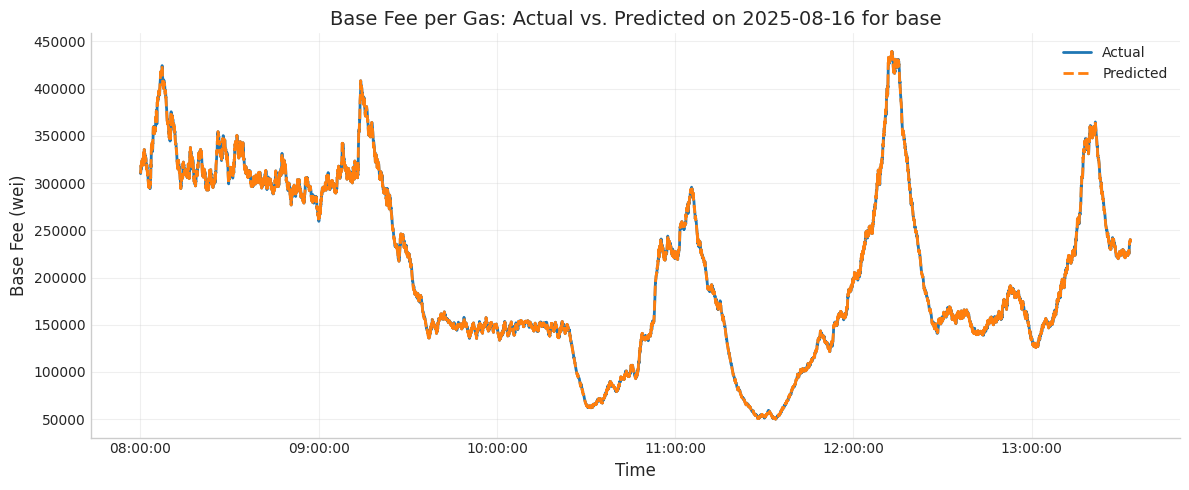

In [11]:

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_output["datetime"], df_output["base_fee_per_gas"], label="Actual", linewidth=2)
ax.plot(df_output["datetime"], df_output["predicted_next_base_fee_per_gas"], label="Predicted", linestyle="--", linewidth=2)
ax.set_title(f"Base Fee per Gas: Actual vs. Predicted on {BLOCK_DATE} for {CHAIN}")
ax.set_xlabel("Time")
ax.set_ylabel("Base Fee (wei)")
ax.legend(frameon=False)

# Format x-axis to show only time (hh:mm:ss)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

## Exploratory Analysis

In [12]:
df_analysis = add_fullness_metrics(df_output, eip1559_elasticity=eip1559_params_output["eip1559_elasticity"])
df_analysis.head()

network,chain_id,timestamp,number,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,withdrawals_root,miner,difficulty,total_difficulty,size,base_fee_per_gas,gas_used,gas_limit,extra_data,transaction_count,chain,dt,datetime,target_gas,base_fee_delta,predicted_next_base_fee_per_gas,actual_next_base_fee_per_gas,next_block_number,is_consecutive,diff,block_fullness,target_fullness,fullness_deviation
str,i32,u32,i64,str,str,str,str,str,str,str,str,str,str,f64,f64,i64,i64,i64,i64,str,i64,str,date,datetime[μs],i64,i64,i64,i64,i64,bool,i64,f64,f64,f64
"""mainnet""",8453,1755302401,34256527,"""0xd9a8786567af855a5b8b2eacb838…","""0x470e3a3c0c1b6be4a8f0d513e843…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xb637b3bf5baeac79dfd9def5eac4…","""0x63f9a66a4ebdd63e9eeba1a10fe6…","""0xa0327908fb9da4f6a598fc62d3c6…","""0x1964cc44f4d6b2845f314983f89e…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,111672,310590,45421791,150000000,"""0x000000003200000003""",224,"""base""",2025-08-16,2025-08-16 08:00:01,50000000,-569,310021,310022,34256528,true,1,0.302812,0.333333,-0.030521
"""mainnet""",8453,1755302403,34256528,"""0x066dca54d9ea94d87b92cfaf00b9…","""0xd9a8786567af855a5b8b2eacb838…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xaebbe25ffcbfbefdf8d4ffbfcbff…","""0x82f7e2321045bfc74acc091b67b5…","""0xfc730d338e7a473c1b08d2cd4210…","""0xf8fb64ad96034073ac3a00de445c…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,129222,310022,74124975,150000000,"""0x000000003200000003""",266,"""base""",2025-08-16,2025-08-16 08:00:03,50000000,2991,313013,313013,34256529,true,0,0.4941665,0.333333,0.160833
"""mainnet""",8453,1755302405,34256529,"""0x9d2b1f1839d805428794cbcff4ee…","""0x066dca54d9ea94d87b92cfaf00b9…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xce726331780b2cfdc500f3bcf3b0…","""0x1374100aca7949d70543cd530bd8…","""0x107e88c97673ef53a9c84ecb38dc…","""0x2b0afc142ad39442cc4f7f35acba…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,126034,313013,51600735,150000000,"""0x000000003200000003""",181,"""base""",2025-08-16,2025-08-16 08:00:05,50000000,200,313213,313213,34256530,true,0,0.3440049,0.333333,0.010672
"""mainnet""",8453,1755302407,34256530,"""0xebdc49bb3f7de0932f61ba39d1f3…","""0x9d2b1f1839d805428794cbcff4ee…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0x5af37f9d79b78e7d973dd6bde3a3…","""0x6634085f1c7b3b7cb14023e2d5b6…","""0x61dd991fb6f9fc477b94b53fe837…","""0xd899a313a0a4417b85450400e0d8…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,117974,313213,54385121,150000000,"""0x000000003200000003""",207,"""base""",2025-08-16,2025-08-16 08:00:07,50000000,549,313762,313762,34256531,true,0,0.362567,0.333333,0.029234
"""mainnet""",8453,1755302409,34256531,"""0xaec559d42b31abe18e4fea7ad424…","""0xebdc49bb3f7de0932f61ba39d1f3…","""0x0000000000000000""","""0x1dcc4de8dec75d7aab85b567b6cc…","""0xffff77fffffffdffd7f4ffffeffd…","""0x12e229cce90a044aa5e553353a68…","""0xa7d57f2763f4f0d99b2fc1b4bd69…","""0x23ee785bc6892d2ac33946ad981d…","""0x9def1847584cc1e75ca95d94992e…","""0x4200000000000000000000000000…",0.0,0.0,272566,313762,77111023,150000000,"""0x000000003200000003""",245,"""base""",2025-08-16,2025-08-16 08:00:09,50000000,3402,317164,317164,34256532,true,0,0.514073,0.333333,0.18074


In [13]:
result = compute_base_fee_elasticity(df_analysis)

print("Elasticity slope:", result["slope"])
print("Intercept:", result["intercept"])

df_metrics = result["df_with_metrics"]

Elasticity slope: -1574.6252397664282
Intercept: -6.827319432738171


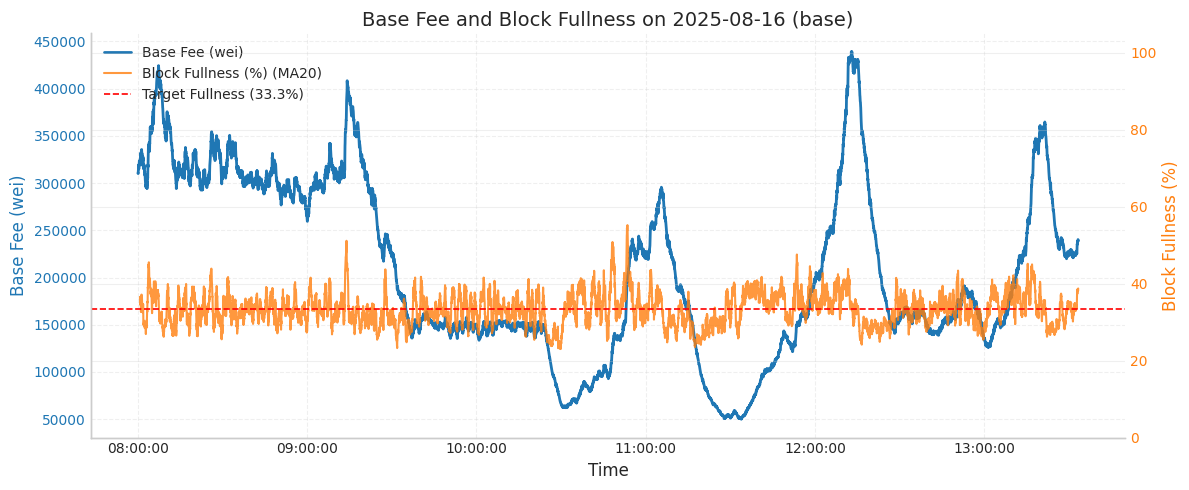

In [27]:
plot_base_fee_and_fullness(df_analysis, CHAIN, BLOCK_DATE, smoothing_window=20)

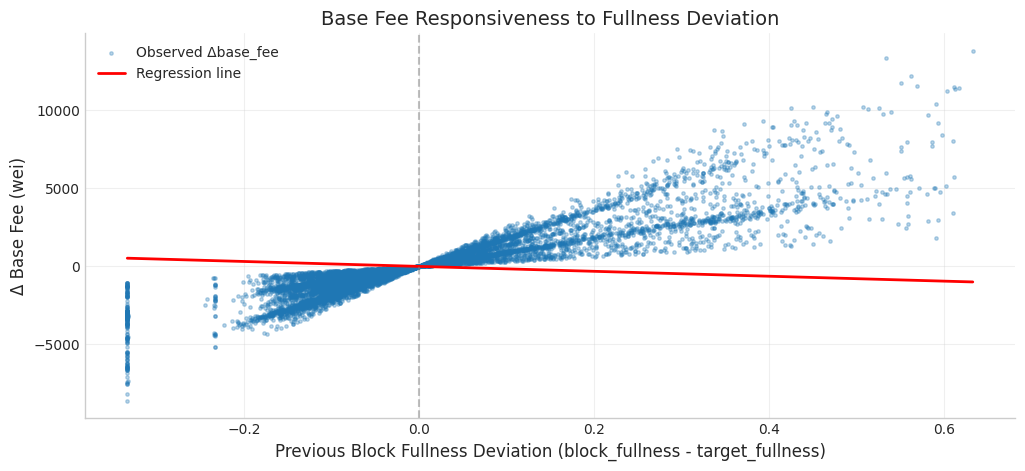

In [15]:
df_plot = result["df_with_metrics"].to_pandas()

# x = df_plot["fullness_deviation"]
x = df_plot["prev_fullness_deviation"]
y = df_plot["base_fee_delta"]

# regression line
x_vals = np.linspace(x.min(), x.max(), 200)
y_vals = result["slope"] * x_vals + result["intercept"]

plt.figure(figsize=(12,5))
plt.scatter(x, y, s=6, alpha=0.3, color="tab:blue", label="Observed Δbase_fee")
plt.plot(x_vals, y_vals, color="red", linewidth=2, label="Regression line")

plt.axvline(0, color="gray", linestyle="--", alpha=0.5)
plt.xlabel("Previous Block Fullness Deviation (block_fullness - target_fullness)")
plt.ylabel("Δ Base Fee (wei)")
plt.title("Base Fee Responsiveness to Fullness Deviation")
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.show()
